In [91]:
import os
import sys
sys.path.append(os.getcwd())

In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Parameters
input_size = 2
hidden_size = 32
output_size = 2
truncate_steps = 20
examples = 1000  # total_examples (num_updates in adder_task)
timesteps = 500  # examples_per_epoch in adder_task
total_size = examples * timesteps  # total_size in adder_task
learning_rate = 0.05
epochs = 100
batch_size = 1000  # Configurable batch size (e.g., 32, 64, 1000 for full-batch)
t1, t2 = 14, 16  # ts in adder_task
tau_task = 1  # Hardcoded tau_task
test_examples = 30  # Configurable number of test examples
test_total_size = test_examples * timesteps
max_norm = 1.0  # Maximum gradient norm for clipping

# Dataset generation functions (reformatted for PyTorch/NumPy)
def generate_add_task_dataset(N, t1, t2, tau_task, seed):
    np.random.seed(seed)
    N = N // tau_task
    x = np.random.binomial(1, 0.5, N).astype(np.float32)  # Bernoulli(0.5)
    y = 0.5 + 0.5 * np.roll(x, t1) - 0.25 * np.roll(x, t2)
    
    X = np.stack([x, 1 - x], axis=1)  # Shape: (N, 2)
    Y = np.stack([y, 1 - y], axis=1)  # Shape: (N, 2)
    
    X = np.tile(X, (tau_task, 1))  # Shape: (N * tau_task, 2)
    Y = np.tile(Y, (tau_task, 1))  # Shape: (N * tau_task, 2)
    return X, Y

def transform(arr, num_updates):
    return arr.reshape((num_updates, -1) + arr.shape[1:])

def adder_task(total_size, t1, t2, tau_task, examples_per_epoch, seed):
    XS, YS = generate_add_task_dataset(total_size, t1, t2, tau_task, seed)
    num_updates = total_size // examples_per_epoch
    XS = transform(XS, num_updates)  # Shape: (num_updates, timesteps, 2)
    YS = transform(YS, num_updates)  # Shape: (num_updates, timesteps, 2)
    return XS, YS

# Generate training dataset
X, Y = adder_task(total_size, t1, t2, tau_task, timesteps, seed=0)

# Convert to PyTorch tensors
X_torch = torch.tensor(X, dtype=torch.float32)
Y_torch = torch.tensor(Y, dtype=torch.float32)

# Verify shapes
assert X_torch.shape == (examples, timesteps, input_size), f"X_torch shape: {X_torch.shape}"
assert Y_torch.shape == (examples, timesteps, output_size), f"Y_torch shape: {Y_torch.shape}"

# Generate test dataset
X_test, Y_test = adder_task(test_total_size, t1, t2, tau_task, timesteps, seed=1)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
Y_test_torch = torch.tensor(Y_test, dtype=torch.float32)

# Verify test dataset shapes
assert X_test_torch.shape == (test_examples, timesteps, input_size), f"X_test_torch shape: {X_test_torch.shape}"
assert Y_test_torch.shape == (test_examples, timesteps, output_size), f"Y_test_torch shape: {Y_test_torch.shape}"

# RNN Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, i_std=1.0):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        # Initialize weights
        W_in = torch.randn(hidden_size, input_size) * np.sqrt(1/input_size) * i_std
        W_rec = torch.linalg.qr(torch.randn(hidden_size, hidden_size))[0] * i_std
        W_out = torch.randn(output_size, hidden_size) * np.sqrt(1/hidden_size) * i_std
        b_rec_ih = torch.zeros(hidden_size)  # Input-hidden bias
        b_rec_hh = torch.zeros(hidden_size)  # Hidden-hidden bias
        b_out = torch.zeros(output_size)
        
        # Register parameters
        self.W_in = nn.Parameter(W_in)
        self.W_rec = nn.Parameter(W_rec)
        self.W_out = nn.Parameter(W_out)
        self.b_rec_ih = nn.Parameter(b_rec_ih)
        self.b_rec_hh = nn.Parameter(b_rec_hh)
        self.b_out = nn.Parameter(b_out)
        
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.rnn.weight_ih_l0 = self.W_in
        self.rnn.weight_hh_l0 = self.W_rec
        self.rnn.bias_ih_l0 = self.b_rec_ih
        self.rnn.bias_hh_l0 = self.b_rec_hh
        self.fc = nn.Linear(hidden_size, output_size)
        self.fc.weight = self.W_out
        self.fc.bias = self.b_out
    
    def forward(self, x, h):
        out, h_next = self.rnn(x, h)
        logits = self.fc(out)
        probs = torch.softmax(logits, dim=-1)
        return logits, probs, h_next

# Initialize model, optimizer, and loss
model = RNN(input_size, hidden_size, output_size, i_std=1.0)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training loop with TBPTT and batching
def train_tbptt(X, Y, model, optimizer, criterion, truncate_steps, batch_size, epochs):
    model.train()
    num_batches = (examples + batch_size - 1) // batch_size
    epoch_losses = []  # Track loss for each epoch
    
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, examples)
            x_batch = X[start_idx:end_idx]
            y_batch = Y[start_idx:end_idx]
            current_batch_size = end_idx - start_idx
            
            # h = torch.zeros(1, current_batch_size, hidden_size)
            h = torch.randn(1, current_batch_size, hidden_size)  # Random initialization
            optimizer.zero_grad()
            
            batch_loss = 0
            for i in range(0, timesteps, truncate_steps):
                seq_start = i
                seq_end = min(i + truncate_steps, timesteps)
                x_chunk = x_batch[:, seq_start:seq_end, :]
                y_chunk = y_batch[:, seq_start:seq_end, :]
                
                h = h.detach()
                logits, probs, h = model(x_chunk, h)
                
                logits = logits.contiguous().view(-1, output_size)
                y_chunk = y_chunk.contiguous().view(-1, output_size)
                
                loss = criterion(logits, y_chunk)
                batch_loss += loss * (seq_end - seq_start) / timesteps
                loss.backward()
            

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()
            total_loss += batch_loss.item()
        
        total_loss /= num_batches
        epoch_losses.append(total_loss)
        if (epoch + 1) % 1 == 0:
            print(f'Epoch {epoch + 1}, Loss: {total_loss:.4f}')
    
    return epoch_losses

# Run training and collect losses
epoch_losses = train_tbptt(X_torch, Y_torch, model, optimizer, criterion, truncate_steps, batch_size, epochs)

Epoch 1, Loss: 0.8177
Epoch 2, Loss: 0.7752
Epoch 3, Loss: 0.7408
Epoch 4, Loss: 0.7141
Epoch 5, Loss: 0.6947
Epoch 6, Loss: 0.6817
Epoch 7, Loss: 0.6738
Epoch 8, Loss: 0.6691
Epoch 9, Loss: 0.6667
Epoch 10, Loss: 0.6655
Epoch 11, Loss: 0.6664
Epoch 12, Loss: 0.6651
Epoch 13, Loss: 0.6658
Epoch 14, Loss: 0.6648
Epoch 15, Loss: 0.6652
Epoch 16, Loss: 0.6644
Epoch 17, Loss: 0.6648
Epoch 18, Loss: 0.6641
Epoch 19, Loss: 0.6645
Epoch 20, Loss: 0.6639
Epoch 21, Loss: 0.6642
Epoch 22, Loss: 0.6637
Epoch 23, Loss: 0.6640
Epoch 24, Loss: 0.6635
Epoch 25, Loss: 0.6637
Epoch 26, Loss: 0.6633
Epoch 27, Loss: 0.6635
Epoch 28, Loss: 0.6631
Epoch 29, Loss: 0.6633
Epoch 30, Loss: 0.6629
Epoch 31, Loss: 0.6631
Epoch 32, Loss: 0.6628
Epoch 33, Loss: 0.6629
Epoch 34, Loss: 0.6626
Epoch 35, Loss: 0.6627
Epoch 36, Loss: 0.6624
Epoch 37, Loss: 0.6626
Epoch 38, Loss: 0.6623
Epoch 39, Loss: 0.6624
Epoch 40, Loss: 0.6621
Epoch 41, Loss: 0.6622
Epoch 42, Loss: 0.6619
Epoch 43, Loss: 0.6620
Epoch 44, Loss: 0.66

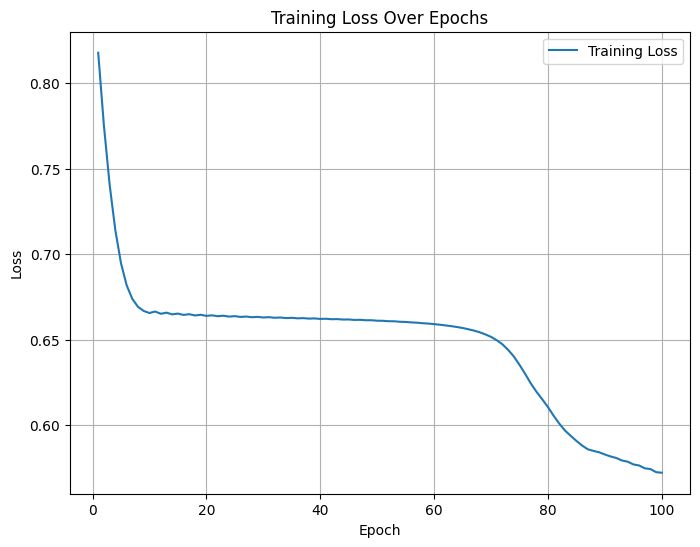

In [93]:

# Plot loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), epoch_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()


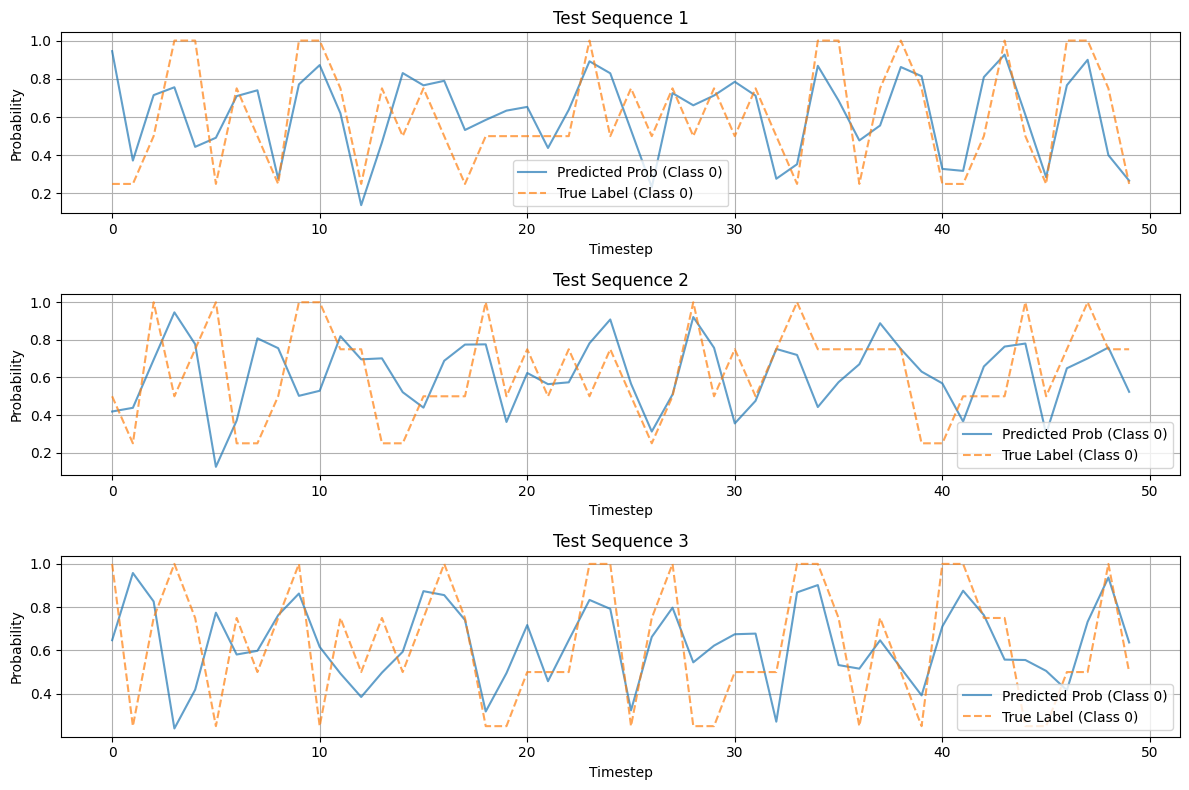

In [94]:
plot_timesteps = 50  # Configurable number of timesteps to plot

# Make predictions on test dataset
model.eval()
with torch.no_grad():
    # h = torch.zeros(1, test_examples, hidden_size)
    h = torch.randn(1, test_examples, hidden_size)  # Random initial hidden state
    logits, probs, _ = model(X_test_torch, h)
    # Extract probabilities for first class (index 0)
    pred_probs = probs[:, :, 0]  # Shape: (test_examples, timesteps)
    true_labels = Y_test_torch[:, :, 0]  # Shape: (test_examples, timesteps)

# Plot predictions vs true labels for first 3 test sequences (first plot_timesteps)
num_sequences_to_plot = min(3, test_examples)
plt.figure(figsize=(12, 8))
for i in range(num_sequences_to_plot):
    plt.subplot(num_sequences_to_plot, 1, i + 1)
    plt.plot(pred_probs[i, :plot_timesteps].numpy(), label='Predicted Prob (Class 0)', alpha=0.7)
    plt.plot(true_labels[i, :plot_timesteps].numpy(), label='True Label (Class 0)', alpha=0.7, linestyle='--')
    plt.title(f'Test Sequence {i + 1}')
    plt.xlabel('Timestep')
    plt.ylabel('Probability')
    plt.grid(True)
    plt.legend()
plt.tight_layout()
